Importing libraries

This version has been used to generate the objective results for both Daytrader and Plants.

In [ ]:
import pandas as pd
import numpy as np
import gdown
from google.colab import files
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import re

# Initialization & Dependencies
* Supply the jar/war file as input into the java code analyzer to generate the dependency file  
* Load the dependency file by providing the location url
* Uncomment for the desired benchmark




In [ ]:
from os import name

#url = 'https://drive.google.com/file/d/1nzbghonX9Hkl-ey5_TAhM5ygHgaWa7ET/view?usp=drive_link' #Daytrader
url = 'https://drive.google.com/file/d/1jq8sgpl4V_t_sPrPP4BxXPVwc5rh3tcS/view?usp=drive_link' #Plants
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.DataFrame()
data = pd.read_csv(path, sep=' ', header=None, names=["caller", "callee"], engine='python', on_bad_lines='warn')

In [ ]:
def is_java_standard_library(method):
  # Using regex to remove any leading characters like '(I)', '(O)', '(M)', '(S)', and potential others before the actual method name
  clean_method = re.sub(r'^\([IOMS]\)', '', method)
  # Split by ':' and take the last part if present, to ensure we're left with 'package.class.method' structure
  clean_method = clean_method.split(':')[-1]
  return clean_method.startswith('java.') or clean_method.startswith('javax.')


# Filter the DataFrame to exclude rows where either 'caller' or 'callee' is from the Java Standard Library
filtered_df = data[~data['caller'].apply(is_java_standard_library) & ~data['callee'].apply(is_java_standard_library)]
#filtered_df = df[~df['caller'].apply(is_java_standard_library) & ~df['callee'].apply(is_java_standard_library)]


print(len(data), " vs. ", len(filtered_df))
filtered_df

#data

2290  vs.  2022


,caller,callee
0,C:com.ibm.websphere.samples.pbw.bean.BackOrderMgr,com.ibm.websphere.samples.pbw.jpa.BackOrder
1,C:com.ibm.websphere.samples.pbw.bean.BackOrderMgr,com.ibm.websphere.samples.pbw.utils.Util
4,C:com.ibm.websphere.samples.pbw.bean.BackOrderMgr,com.ibm.websphere.samples.pbw.jpa.Inventory
6,C:com.ibm.websphere.samples.pbw.bean.BackOrderMgr,com.ibm.websphere.samples.pbw.bean.BackOrderMgr
15,C:com.ibm.websphere.samples.pbw.bean.CatalogMgr,com.ibm.websphere.samples.pbw.jpa.Inventory
...,...,...
2285,M:com.ibm.websphere.samples.pbw.war.ValidatorU...,(M)javax.faces.application.FacesMessage:setSev...
2286,M:com.ibm.websphere.samples.pbw.war.ValidatorU...,(O)javax.faces.validator.ValidatorException:<i...
2287,M:com.ibm.websphere.samples.pbw.war.ValidatorU...,(M)javax.faces.component.UIComponent:getAttrib...
2288,M:com.ibm.websphere.samples.pbw.war.ValidatorU...,(I)java.util.Map:get(java.lang.Object)


# **Data Preprocessing**


*   **Extracting** methods
*   **Tagging**: caller => callee
*   **Parsing**: identify relevant information
*   **Data structuring**: Methods are nodes with package, class methodName, id and stored in a dataframe.






In [ ]:
# Source nodes
extracted_info_caller = []
idxInitial = np.where(data['caller'].str.startswith('M:'))[0][0]
data_methods = data.iloc[idxInitial:]

for line in data_methods['caller']:
    if line.startswith('M:'):
      parts = line.split()
      package_class_method_part = parts[0][2:]
      package_class_name, method_part = package_class_method_part.split(':')
      method_name = method_part.split('(')[0]
      class_name = package_class_name.split('.')[-1]
      package_name = package_class_name.split('.')[-2]
      extracted_info_caller.append({'package': package_name, 'class': class_name, 'method': method_name})

Applying a similar process on the callee column of our dataset

In [ ]:
# Target nodes
extracted_info_callee = []
calltypes = []

for line in data_methods['callee']:
  if line.startswith('('):
    calltypes.append(line[1])
    parts = line.split()
    package_class_method_part = parts[0][2:]
    package_class_name, method_part = package_class_method_part.split(':')
    method_name = method_part.split('(')[0]
    class_name = package_class_name.split('.')[-1]
    package_name = package_class_name.split('.')[-2]
    extracted_info_callee.append({'package': package_name, 'class': class_name, 'method': method_name})

Counting the number of distinct methods before further processing.

In [ ]:
data_classes = data[data['caller'].str.startswith('C:')]
print(extracted_info_caller)
print("-------------------------------------------------------------------------")
print()
print(extracted_info_callee)
print("*********************************************************************************************")

# Combine dictionaries from both lists
combined_list = extracted_info_caller + extracted_info_callee

# Create a set to store unique combinations
unique_combinations = set()

# Iterate through the combined list and add unique combinations to the set based on method names
for item in combined_list:
    combination = (item['method'])
    unique_combinations.add(combination)

unique_dependencies = set()
# Iterate through the combined list and add unique combinations to the set
for item2 in combined_list:
    combination = (item2['method'], item2['class'], item2['package'])
    unique_dependencies.add(combination)

# Count the number of unique combinations
unique_count = len(unique_combinations)
unique_dependencies_count = len(unique_dependencies)

print(f"Number of unique methods: {unique_count} vs {unique_dependencies_count} unique combinations of package, class and methods.")

print("All methods dataframe = ", len(data_methods), " vs Initial input = ", len(data), " vs class dataframe = ", len(data_classes))
print("All caller methods processed = ", len(extracted_info_caller))
print("Callee methods after processing = ", len(extracted_info_callee))

[{'package': 'bean', 'class': 'BackOrderMgr', 'method': '<init>'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'BackOrderMgr', 'method': 'createBackOrder'}, {'package': 'bean', 'class': 'Bac

# Data Structuring

In [ ]:
# Dataframe for caller method dependencies from our dataframe, data_methods
source_df = pd.DataFrame(extracted_info_caller)

# Daframe for callee method dependencies
target_df = pd.DataFrame(extracted_info_callee)

print(len(source_df), " source method calls  ******   ", len(target_df), " target method calls")
source_df
# Concatenate the DataFrames to create a unified DataFrame
#merged_df = pd.concat([source_df, target_df], ignore_index=True)
#merged_df = pd.concat([source_df, target_df], ignore_index=True)


1885  source method calls  ******    1885  target method calls


,package,class,method
0,bean,BackOrderMgr,<init>
1,bean,BackOrderMgr,createBackOrder
2,bean,BackOrderMgr,createBackOrder
3,bean,BackOrderMgr,createBackOrder
4,bean,BackOrderMgr,createBackOrder
...,...,...,...
1880,war,ValidatorUtils,addErrorMessage
1881,war,ValidatorUtils,addErrorMessage
1882,war,ValidatorUtils,addErrorMessage
1883,war,ValidatorUtils,addErrorMessage


# Dependency Graph
Creating a graph structure with the NetworkX library

In [ ]:
import networkx as nx

# Create a NetworkX graph
G = nx.DiGraph()

# Add nodes with attributes from the source method calls to the graph
for item in extracted_info_caller:
  unique_id = f"{item['package']}_{item['class']}_{item['method']}"
  G.add_node(unique_id, method_name=item['method'], package=item['package'], class_name=item['class'])


# Same process from the target method calls
for item in extracted_info_callee:
  unique_id = f"{item['package']}_{item['class']}_{item['method']}"
  G.add_node(unique_id, method_name=item['method'] , package=item['package'], class_name=item['class'])


# Now, edges between source and target
for caller, callee in zip(extracted_info_caller, extracted_info_callee):
  source_id = f"{caller['package']}_{caller['class']}_{caller['method']}"
  target_id = f"{callee['package']}_{callee['class']}_{callee['method']}"
  G.add_edge(source_id, target_id)


# Print the graph nodes and edges
print("Nodes:", G.nodes(data=True))
print("Edges:", G.edges())

# Example of accessing node attributes:
print("Node count attributes:", len(list(G.nodes)))
print("Edge count attributes:", len(list(G.edges)))


Nodes: [('bean_BackOrderMgr_<init>', {'method_name': '<init>', 'package': 'bean', 'class_name': 'BackOrderMgr'}), ('bean_BackOrderMgr_createBackOrder', {'method_name': 'createBackOrder', 'package': 'bean', 'class_name': 'BackOrderMgr'}), ('bean_BackOrderMgr_findBackOrders', {'method_name': 'findBackOrders', 'package': 'bean', 'class_name': 'BackOrderMgr'}), ('bean_BackOrderMgr_deleteBackOrder', {'method_name': 'deleteBackOrder', 'package': 'bean', 'class_name': 'BackOrderMgr'}), ('bean_BackOrderMgr_updateStock', {'method_name': 'updateStock', 'package': 'bean', 'class_name': 'BackOrderMgr'}), ('bean_BackOrderMgr_getBackOrderInventoryID', {'method_name': 'getBackOrderInventoryID', 'package': 'bean', 'class_name': 'BackOrderMgr'}), ('bean_BackOrderMgr_getBackOrderQuantity', {'method_name': 'getBackOrderQuantity', 'package': 'bean', 'class_name': 'BackOrderMgr'}), ('bean_BackOrderMgr_setBackOrderQuantity', {'method_name': 'setBackOrderQuantity', 'package': 'bean', 'class_name': 'BackOrder

# Meta-data
* Unique methods count
* Set of methods

In [ ]:
#methods_in_microservice = pd.DataFrame(list(G.nodes), columns=['visits-service'])
#methods_in_microservice.to_csv("visits-service-microservice.csv")



**Visual representation of the dependency graph**

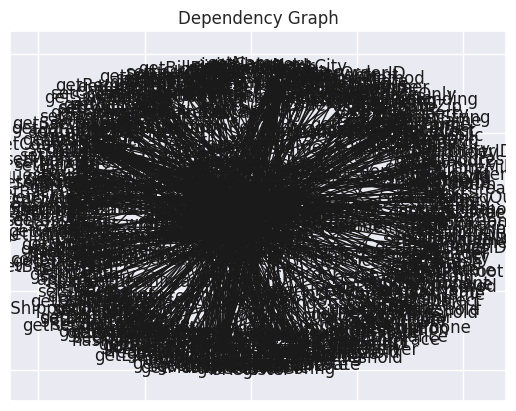

In [ ]:
pos = nx.spring_layout(G, seed=42)

# Draw nodes with labels
#nx.draw(G, pos, with_labels = True, node_color='skyblue', node_size=20)

nx.draw_networkx_labels(G, pos, labels={node: G.nodes[node]['method_name'] for node in G.nodes})

# Draw edges
nx.draw_networkx_edges(G, pos)

# Display the plot
plt.title('Dependency Graph')
plt.show()

# Analysis

In [ ]:
# Structural
for node, info in (G.nodes(data=True)):
  print(f"Node {node}: Method={info['method_name']}, Class= {info['class_name']}")

Node bean_BackOrderMgr_<init>: Method=<init>, Class= BackOrderMgr
Node bean_BackOrderMgr_createBackOrder: Method=createBackOrder, Class= BackOrderMgr
Node bean_BackOrderMgr_findBackOrders: Method=findBackOrders, Class= BackOrderMgr
Node bean_BackOrderMgr_deleteBackOrder: Method=deleteBackOrder, Class= BackOrderMgr
Node bean_BackOrderMgr_updateStock: Method=updateStock, Class= BackOrderMgr
Node bean_BackOrderMgr_getBackOrderInventoryID: Method=getBackOrderInventoryID, Class= BackOrderMgr
Node bean_BackOrderMgr_getBackOrderQuantity: Method=getBackOrderQuantity, Class= BackOrderMgr
Node bean_BackOrderMgr_setBackOrderQuantity: Method=setBackOrderQuantity, Class= BackOrderMgr
Node bean_BackOrderMgr_setBackOrderStatus: Method=setBackOrderStatus, Class= BackOrderMgr
Node bean_BackOrderMgr_setBackOrderOrderDate: Method=setBackOrderOrderDate, Class= BackOrderMgr
Node bean_CatalogMgr_<init>: Method=<init>, Class= CatalogMgr
Node bean_CatalogMgr_getItemsByCategory: Method=getItemsByCategory, Clas

In [ ]:
!pip install pymoo sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 30.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210078 sha256=934936b9fc57f389e73cc2021811681f328c886c3b450762149d4e6899bea8a2
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [ ]:
from sentence_transformers import SentenceTransformer

# Semantic
method_nodes = method_names = [info['method_name'] for node, info in G.nodes(data=True)]
model = SentenceTransformer('bert-base-nli-mean-tokens')
method_embeddings = [model.encode(nodes, convert_to_tensor=True) for nodes in method_nodes]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#**Multi-Objective Algorithm: NSGA-III**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.core.problem import Problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.operators.crossover.pntx import TwoPointCrossover

from pymoo.optimize import minimize
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random

**Problem Class Definition**

In [ ]:
# Variables
node_embeddings = method_embeddings
graph = G

In [ ]:
class GraphProblem(Problem):
    # Constructor for the problem object
    def __init__(self, graph, num_clusters, method_embeddings):
        self.graph = graph
        self.num_clusters = num_clusters
        self.num_nodes = len(graph.nodes)
        self.method_embeddings = method_embeddings

        super().__init__(n_var = self.num_nodes,
                         n_obj = 3,
                         xl = np.zeros(self.num_nodes),
                         xu = np.full(self.num_nodes, self.num_clusters -1)
                         )

    # Can serve to generate the initial population: A matrix showcasing the graph nodes distributed in (num clusters) partitions
    # Assigns clusters to each individual (node) in the population with the constraint
    # that each cluster has at least one node
    def distribute_into_clusters(self, pop, n_clusters):
      distributed_pop = np.zeros(len(pop), dtype = int)

      # Validating the constraint
      for i in range(n_clusters):
        nodes_idx = np.where(distributed_pop == i)[0]
        if (len(nodes_idx)) > 0:
          continue

        current_nodes = np.where(distributed_pop == -1)[0]

        if (len(current_nodes)) > 0:
          picked_node = np.random.choice(current_nodes)
          distributed_pop[picked_node] = i

      # Assigning randomly each node left to a cluster
      nodes_left = np.where(distributed_pop == -1)[0]
      for idx in range(len(pop)):
        distributed_pop[idx] = np.random.randint(0, n_clusters)

      return distributed_pop


    # Objective functions
    # coupling function
    def compute_overall_coupling(self, clusters):
      num_clusters = len(clusters)
      total_edges = len(list(self.graph.edges))
      overall_coupling = 0.0

      for i in range(self.num_clusters):
        for j in range(i + 1, self.num_clusters):
          cluster_i = clusters[i]
          cluster_j = clusters[j]

          # Calculate the number of edges between nodes in the two clusters
          coupling_pair = len([edge for edge in self.graph.edges if edge[0] in cluster_i and edge[1] in cluster_j])
          overall_coupling += coupling_pair

      # Calculate the average coupling
      return overall_coupling / total_edges


    # cohesion function
    def cohesion(self, cluster):
      internal_edges = self.graph.subgraph(cluster).edges
      return len(internal_edges) / len(cluster) if len(cluster) > 0 and len(internal_edges) > 0 else 0.0

    # average cohesion
    def compute_average_cohesion(self, clusters):
      total_cohesion = sum(self.cohesion(cluster) for cluster in clusters)

      if self.num_clusters > 0:
        average_cohesion = total_cohesion / self.num_clusters
      else:
        average_cohesion = 0.0

      return -average_cohesion


    # Semantic distance
    def compute_semantic_distance(self, clusters):
      cluster_embeddings = self.method_embeddings
      semantic_distances = np.zeros((self.num_clusters, self.num_clusters))


      for i in range(self.num_clusters):
        for j in range(i + 1, self.num_clusters):
          similarity_matrix = cosine_similarity(cluster_embeddings[i].reshape(1,-1),
                                                cluster_embeddings[j].reshape(1,-1))

          semantic_distances[i, j] = 1.0 - similarity_matrix.item()
          semantic_distances[j, i] = semantic_distances[i, j]

      avg_semantic_distance = np.sum(semantic_distances) / (self.num_clusters * (self.num_clusters - 1) / 2)

      return -avg_semantic_distance


    # Fitness function
    def _evaluate(self, x, out, *args, **kwargs):
      # get the size of the population
      N = x.shape[0]

      clusters = []
      # Assign individuals (nodes) randomly to clusters
      cluster_assignments = self.distribute_into_clusters(x, self.num_clusters)


      # get the nodes content of each cluster using the cluster_assignments
      for i in range(self.num_clusters):
        cluster_indices = np.where(cluster_assignments == i)[0]
        cluster_nodes = [list(self.graph.nodes)[j] for j in cluster_indices]
        clusters.append(cluster_nodes)

      # Placeholder for objective function values
      F = np.zeros((N, self.n_obj))

      # Evaluate objectives for each cluster
      for i in range(N):
        coupling = self.compute_overall_coupling(clusters)
        cohesion = self.compute_average_cohesion(clusters)
        sem_distance = self.compute_semantic_distance(clusters)
        F[i, :] = [coupling, cohesion, sem_distance]

      out["F"] = F

**Instantiation & Execution**

In [ ]:
suite = [3,5,8,10]

for a in suite:
  # Create instance of the problem object
  desired_number_of_partitions = a
  problem = GraphProblem(graph, desired_number_of_partitions, method_embeddings)

  # Instance of the algorithm object
  ref_dirs = get_reference_directions("das-dennis", problem.n_obj, n_partitions=desired_number_of_partitions)
  algorithm = NSGA3(pop_size=problem.n_var, ref_dirs=ref_dirs)
  #sampling = problem.distribute_into_clusters(graph.nodes, desired_number_of_partitions)
  crossover= TwoPointCrossover()
  #mutation =


  # Execution
  result = minimize(problem,
                    algorithm,
                    ('n_gen', 50),
                    #crossover=crossover,
                    #sampling=sampling,
                    seed=1,
                    verbose=True)
  print()
  print("**************************************************************************")
  print()

  # **Results**
  # Final solutions
  final_solutions = result.X
  print("Final Solutions:")
  print(final_solutions)
  print()
  print("**************************************************************************")
  print()
  #Representation of the solution**

  #   Get the best clustering assignment
  #   Generate the node content of each of these clusters


  best_solution_idx = 0
  best_clustering = final_solutions[best_solution_idx]
  clustered_solution = np.round(best_clustering).astype(int)
  print("Population size = ", len(clustered_solution))
  print()
  print("Individuals : ", clustered_solution)

  print()
  print("**************************************************************************")
  print()

  ##Converting the clustering assignment to a list of the nodes contained in the different clusters.
  # get the nodes content of each cluster using the cluster_assignments
  clusters_content = []
  clusters_fullnaming = []
  for i in range(problem.num_clusters):
    cluster_idx = np.where(clustered_solution == i)[0]
    node_list = [list(problem.graph.nodes)[j] for j in cluster_idx]
    method_names = [node.split('_')[-1] for node in node_list]
    full_naming = [node.split('_')[-3] + "." + node.split('_')[-2] + "." + node.split('_')[-1] for node in node_list]
    print("Nodes in Cluster ", i, " = ", (full_naming))
    clusters_content.append(method_names)
    clusters_fullnaming.append(full_naming)
  # Visualisation of clusters in table
  # Solution lists stored into dataframes
  solution_df = pd.DataFrame(clusters_content)
  solution_full_naming_df = pd.DataFrame(clusters_fullnaming)

  # dataframe with only method names shown in clusters
  df2 = solution_df.transpose()
  df2.columns = [f"Cluster {i+1}" for i in range(len(clusters_content))]

  # dataframe with method names and their associated classes
  df3 = solution_full_naming_df.transpose()
  df3.columns = [f"Cluster {i+1}" for i in range(len(clusters_fullnaming))]

  location = '/content/drive/MyDrive/Data -- Dependencies/Benchmark/Plants/Results/Feb 19/'
  df2.to_csv(location+f"{desired_number_of_partitions}clusters-Feb19-plants-processed-MicID.csv", index=False)
  df3.to_csv(location+f"{desired_number_of_partitions}Feb19-Fullname_plants_MicID_processed.csv", index=False)
  print()
  print("**************************************************************************")
  print()

  ##Pareto front**
  #Objective function values of the non-dominated solutions
  pareto_front = result.F
  print("Pareto-front")
  print(pareto_front)
  ##Numerical Representation of the Pareto Front
  pareto_df = pd.DataFrame(np.round(pareto_front, decimals = 3), columns = ['Coupling', 'Cohesion', 'Semantic distance'])
  pareto_df.to_csv(location + f"{desired_number_of_partitions}-Pareto-plants-Feb19.csv", index=False)
  print()
  print("**************************************************************************")
  print()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      535 |      1 |             - |             -
     2 |     1070 |      2 |  1.0000000000 |         ideal
     3 |     1605 |      3 |  0.2474055322 |         ideal
     4 |     2140 |      3 |  0.2936238460 |         ideal
     5 |     2675 |      3 |  0.000000E+00 |             f
     6 |     3210 |      3 |  0.000000E+00 |             f
     7 |     3745 |      3 |  0.000000E+00 |             f
     8 |     4280 |      3 |  0.000000E+00 |             f
     9 |     4815 |      3 |  0.000000E+00 |             f
    10 |     5350 |      3 |  0.000000E+00 |             f
    11 |     5885 |      3 |  0.000000E+00 |             f
    12 |     6420 |      3 |  0.000000E+00 |             f
    13 |     6955 |      3 |  0.1884382512 |             f
    14 |     7490 |      4 |  0.0749200795 |             f
    15 |     8025 |      3 |  0.3492435146 |         ideal
    16 |     8560 |      4 |  0.1094507466 |            